In [4]:
# imports and setup
%matplotlib inline

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd

import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import linear_model

pd.set_option('precision', 2) # number precision for pandas
pd.set_option('display.max_rows', 10)
pd.set_option('display.float_format', '{:20,.2f}'.format) # get rid of scientific notation
plt.style.use('seaborn') # pretty matplotlib plots

/Users/emredjan/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 8.a

In [5]:
auto = pd.read_csv('../datasets/Auto.csv', index_col='name', na_values=['?'])
auto.dropna(inplace=True)

In [6]:
lm1 = smf.ols(formula='mpg ~ horsepower', data=auto)

lm1_fit = lm1.fit()
lm1_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Mon, 10 Jul 2017   Prob (F-statistic):           7.03e-81
Time:                        20:55:55   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     39.9359      0.717     55.660      0.000      38.525      41.347
horsepower    -0.1578      0.006    -24.489      0.000      -0.171      -0.145
==============================================================================
Omnibus:                       16.432   Durbin-Watson:                   0.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.305
Skew:                           0.492   Prob(JB):                     0.000175
Kurtosis:                       3.299   Cond. No.                         322.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- i & ii : There is a strong relationship (horsepower p-value << 0.000)
- iii : negative (coeff < 0)

In [7]:
# iv
from sklearn import linear_model

# ols model with intercept
lm1_sl = linear_model.LinearRegression(fit_intercept=True) 

# fitted ols model (.values.reshape(-1, 1) is required for single predictor?)
x_train = auto['horsepower'].values.reshape(-1, 1)
y_train = auto['mpg']
lm1_sl.fit(x_train, y_train)

# summary
lm1_sl.intercept_, lm1_sl.coef_

lm1_sl.predict(np.array([98]).reshape(-1, 1))

array([ 24.46707715])

# 8.b & 8.c

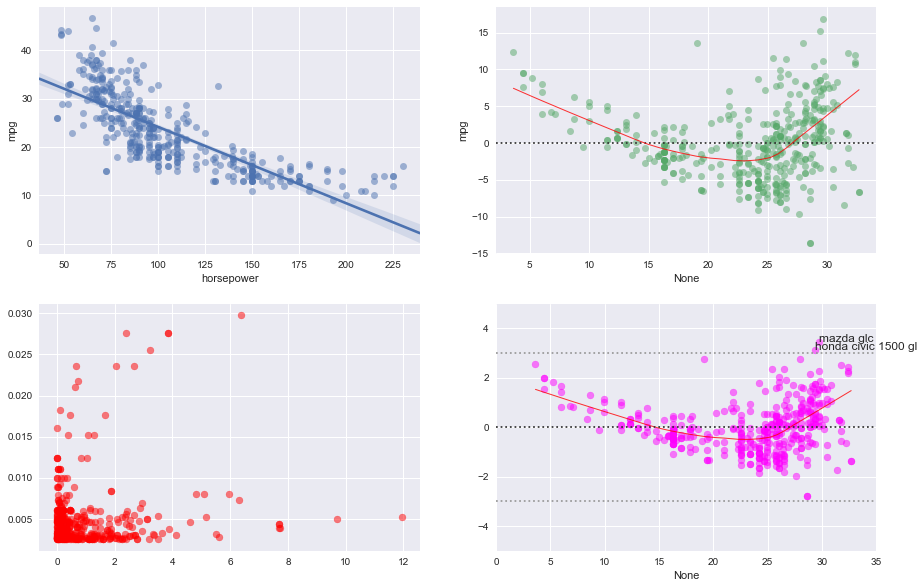

In [8]:
from statsmodels.graphics.regressionplots import *
from scipy.stats import zscore

y_pred = lm1_fit.predict(sm.add_constant(auto['horsepower']))

lm1_resid = lm1_fit.resid # residuals
lm1_resid_stud = lm1_fit.get_influence().resid_studentized_internal # studentized residuals

norm_resid = zscore(lm1_resid)
leverage = lm1_fit.get_influence().hat_matrix_diag

f, axes = plt.subplots(2, 2, sharex=False, sharey=False) 
f.set_figheight(10)
f.set_figwidth(15)

sns.regplot('horsepower', 'mpg', data=auto, ax=axes[0, 0], scatter_kws={'alpha': '0.5'}) # regression plot
sns.residplot(y_pred, 'mpg', data=auto, ax=axes[0, 1], lowess=True, 
              scatter_kws={'alpha': '0.5'},
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}) # residual plot

# leverage plot

norm_resid = zscore(lm1_resid)
leverage = lm1_fit.get_influence().hat_matrix_diag
axes[1, 0].autoscale(enable=True, axis='y', tight=True)
axes[1, 0].scatter(norm_resid ** 2, leverage, alpha=0.5, color='red')

# studentized residual plot
axes[1, 1].scatter(y_pred, lm1_resid_stud, alpha=0.5, color='magenta')
sns.regplot(y_pred, lm1_resid_stud, ax=axes[1, 1], scatter=False, ci=False, lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
axes[1, 1].axhline(0, ls=":", c=".2")
axes[1, 1].axhline(-3, ls=":", c=".6")
axes[1, 1].axhline(3, ls=":", c=".6")
axes[1, 1].set_xlim(0, 35);
axes[1, 1].set_ylim(-5, 5);

x = y_pred[np.logical_or(lm1_resid_stud > 3, lm1_resid_stud < -3)]
y = lm1_resid_stud[np.logical_or(lm1_resid_stud > 3, lm1_resid_stud < -3)]

for i, x, y in zip(x.index, x, y):
    axes[1, 1].annotate(i, xy=(x, y));

# 9.a

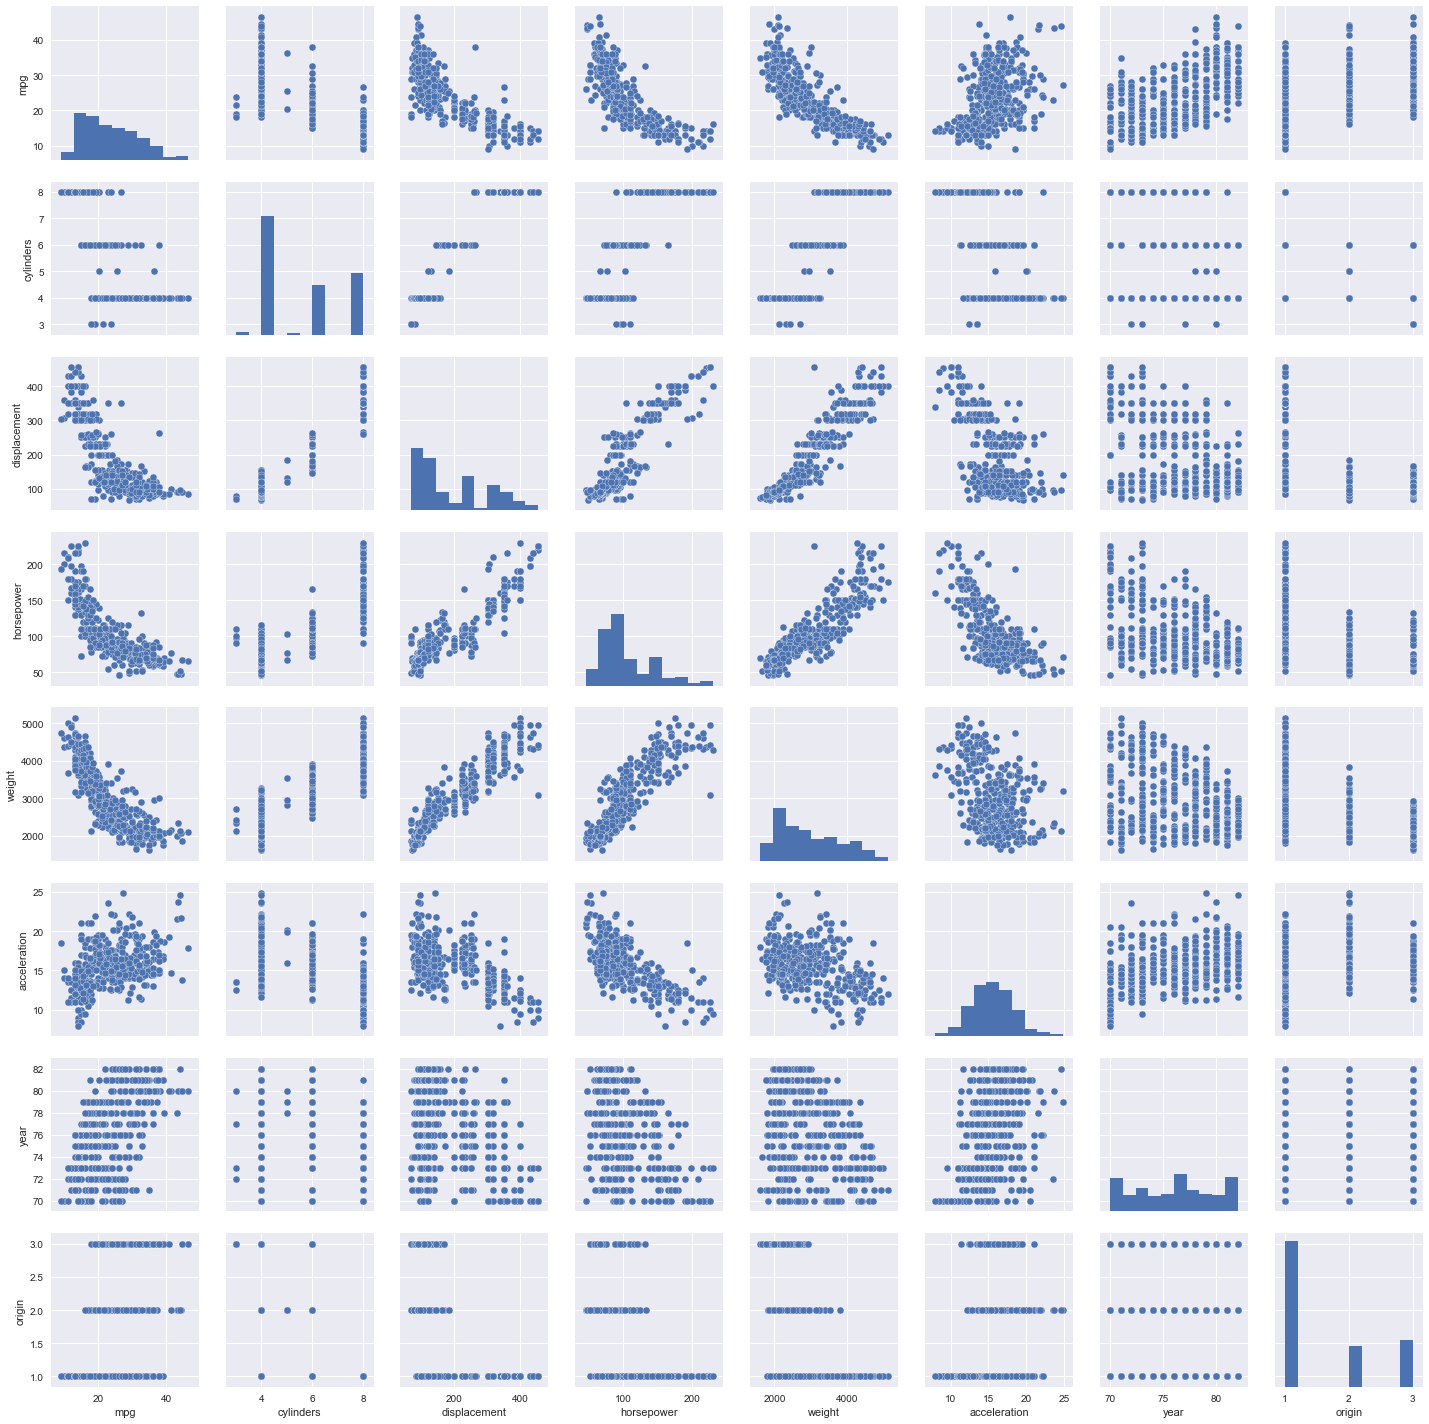

In [9]:
sns.pairplot(auto);

# 9.b

In [10]:
auto.corr()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
mpg,1.00,-0.78,-0.81,-0.78,-0.83,0.42,0.58,0.57
cylinders,-0.78,1.00,0.95,0.84,0.90,-0.50,-0.35,-0.57
displacement,-0.81,0.95,1.00,0.90,0.93,-0.54,-0.37,-0.61
horsepower,-0.78,0.84,0.90,1.00,0.86,-0.69,-0.42,-0.46
weight,-0.83,0.90,0.93,0.86,1.00,-0.42,-0.31,-0.59
acceleration,0.42,-0.50,-0.54,-0.69,-0.42,1.00,0.29,0.21
year,0.58,-0.35,-0.37,-0.42,-0.31,0.29,1.00,0.18
origin,0.57,-0.57,-0.61,-0.46,-0.59,0.21,0.18,1.00


# 9.c

In [11]:
def ols_formula(df, dependent_var, *excluded_cols):
    '''
    Generates the R style formula for statsmodels (patsy) given
    the dataframe, dependent variable and optional excluded columns
    as strings
    '''
    df_columns = list(df.columns.values)
    df_columns.remove(dependent_var)
    for col in excluded_cols:
        df_columns.remove(col)
    return dependent_var + ' ~ ' + ' + '.join(df_columns)

In [13]:
form = ols_formula(auto, 'mpg')

lm2_fit = smf.ols(formula=form, data=auto).fit()

lm2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     252.4
Date:                Mon, 10 Jul 2017   Prob (F-statistic):          2.04e-139
Time:                        20:56:26   Log-Likelihood:                -1023.5
No. Observations:                 392   AIC:                             2063.
Df Residuals:                     384   BIC:                             2095.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -17.2184      4.644     -3.707      0.000     -26.350      -8.087
cylinders       -0.4934      0.323     -1.526      0.128      -1.129       0.142
displacement     0.0199      0.008      2.647      0.008       0.005       0.035
horsepower      -0.0170      0.014     -1.230      0.220      -0.044       0.010
weight          -0.0065      0.001     -9.929      0.000      -0.008      -0.005
acceleration     0.0806      0.099      0.815      0.415      -0.114       0.275
year             0.7508      0.051     14.729      0.000       0.651       0.851
origin           1.4261      0.278      5.127      0.000       0.879       1.973
==============================================================================
Omnibus:                       31.906   Durbin-Watson:                   1.309
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.100
Skew:                           0.529   Prob(JB):                     2.95e-12
Kurtosis:                       4.460   Cond. No.                     8.59e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.59e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- i : not all of them (p values)
- ii : displacement, weight, year, origin
- iii : a change of 1 year results in 0.75 miles per gallon

# 9.d

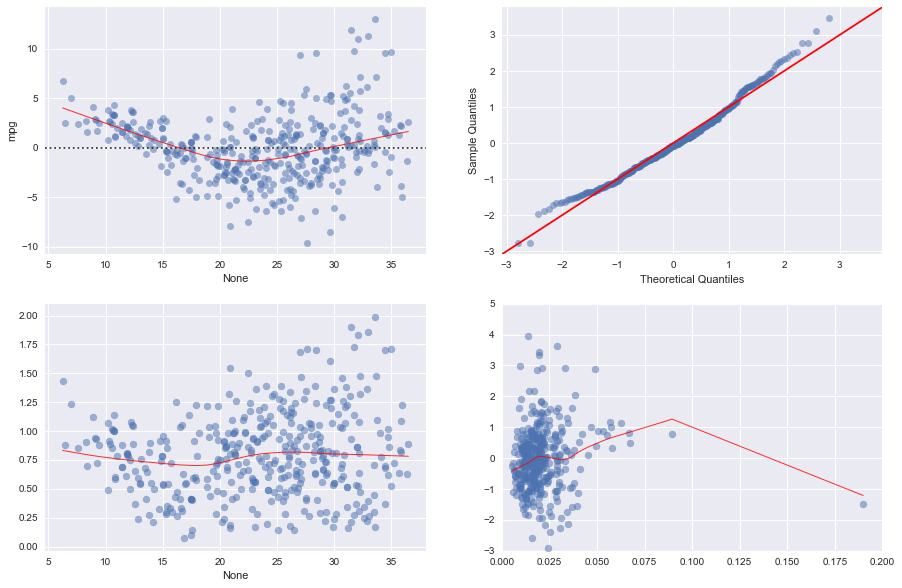

In [16]:
from statsmodels.graphics.regressionplots import *
from statsmodels.graphics.gofplots import *

y_pred = lm2_fit.predict()

f, axes = plt.subplots(2, 2, sharex=False, sharey=False) 
f.set_figheight(10)
f.set_figwidth(15)

# residual plot
sns.residplot(y_pred, 'mpg', data=auto, ax=axes[0, 0],  
              lowess=True, 
              scatter_kws={'alpha': 0.5},
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}) # residual plot

# qq plot
lm2_norm_resid = zscore(lm2_fit.resid)
qq = ProbPlot(lm2_norm_resid)
qq.qqplot(ax=axes[0, 1], line='45', alpha=0.5, color='#4C72B0', lw=1)

# scale-location plot
lm2_norm_resid_abssq = np.sqrt(np.abs(lm2_norm_resid))

axes[1, 0].scatter(y_pred, lm2_norm_resid_abssq, alpha=0.5)
sns.regplot(y_pred, lm2_norm_resid_abssq, ax=axes[1, 0], scatter=False, ci=False, lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

# leverage plot
#plot_leverage_resid2(lm2_fit, ax=axes[1, 1]);


leverage = lm2_fit.get_influence().hat_matrix_diag
axes[1, 1].scatter(leverage, lm2_norm_resid, alpha=0.5)
sns.regplot(leverage, lm2_norm_resid, ax=axes[1, 1], scatter=False, ci=False, lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
axes[1, 1].set_xlim(0, 0.20);
axes[1, 1].set_ylim(-3, 5);

# 9.e

In [11]:
form = ols_formula(auto, 'mpg')

lm3_fit = smf.ols(formula=form + ' + horsepower:weight + displacement:acceleration', data=auto).fit()

lm3_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     272.9
Date:                Mon, 03 Jul 2017   Prob (F-statistic):          2.32e-160
Time:                        22:54:10   Log-Likelihood:                -968.13
No. Observations:                 392   AIC:                             1956.
Df Residuals:                     382   BIC:                             1996.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -6.0876      5.275     -1.154      0.249     -16.459       4.284
cylinders                     0.1321      0.289      0.457      0.648      -0.437       0.701
displacement                  0.0315      0.010      3.014      0.003       0.011       0.052
horsepower                   -0.2172      0.024     -9.138      0.000      -0.264      -0.170
weight                       -0.0095      0.001    -10.411      0.000      -0.011      -0.008
acceleration                  0.2483      0.138      1.801      0.072      -0.023       0.519
year                          0.7766      0.044     17.465      0.000       0.689       0.864
origin                        0.7507      0.250      3.006      0.003       0.260       1.242
horsepower:weight          4.706e-05   5.78e-06      8.145      0.000    3.57e-05    5.84e-05
displacement:acceleration    -0.0023      0.001     -3.178      0.002      -0.004      -0.001
==============================================================================
Omnibus:                       38.524   Durbin-Watson:                   1.526
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.918
Skew:                           0.601   Prob(JB):                     1.79e-15
Kurtosis:                       4.647   Cond. No.                     1.46e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.46e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# 9.f

In [12]:
lm4_fit = smf.ols(formula='mpg ~ np.log(cylinders) + displacement + horsepower + \
                           np.power(horsepower,2) + weight + acceleration + year + origin', 
                  data=auto).fit()

lm4_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     282.0
Date:                Mon, 03 Jul 2017   Prob (F-statistic):          2.28e-155
Time:                        22:54:10   Log-Likelihood:                -982.89
No. Observations:                 392   AIC:                             1984.
Df Residuals:                     383   BIC:                             2020.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.7721      4.777      0.162      0.872      -8.620      10.164
np.log(cylinders)           0.9813      1.642      0.598      0.550      -2.247       4.210
displacement               -0.0047      0.007     -0.643      0.521      -0.019       0.010
horsepower                 -0.3154      0.034     -9.144      0.000      -0.383      -0.248
np.power(horsepower, 2)     0.0010      0.000      9.197      0.000       0.001       0.001
weight                     -0.0033      0.001     -4.825      0.000      -0.005      -0.002
acceleration               -0.3281      0.100     -3.292      0.001      -0.524      -0.132
year                        0.7353      0.046     15.968      0.000       0.645       0.826
origin                      1.0406      0.254      4.104      0.000       0.542       1.539
==============================================================================
Omnibus:                       28.513   Durbin-Watson:                   1.543
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.801
Skew:                           0.477   Prob(JB):                     4.17e-11
Kurtosis:                       4.420   Cond. No.                     5.07e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.07e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# 10.a

In [13]:
carseats = pd.read_csv('../datasets/Carseats.csv', index_col=0)
carseats

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
1,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
2,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
3,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
4,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
5,4.15,141,64,3,340,128,Bad,38,13,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...
396,12.57,138,108,17,203,128,Good,33,14,Yes,Yes
397,6.14,139,23,3,37,120,Medium,55,11,No,Yes
398,7.41,162,26,12,368,159,Medium,40,18,Yes,Yes
399,5.94,100,79,7,284,95,Bad,50,12,Yes,Yes


In [14]:
lm5_fit = smf.ols(formula='Sales ~ Price + Urban + US', 
                  data=carseats).fit()

lm5_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     41.52
Date:                Mon, 03 Jul 2017   Prob (F-statistic):           2.39e-23
Time:                        22:54:10   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1863.
Df Residuals:                     396   BIC:                             1879.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       13.0435      0.651     20.036      0.000      11.764      14.323
Urban[T.Yes]    -0.0219      0.272     -0.081      0.936      -0.556       0.512
US[T.Yes]        1.2006      0.259      4.635      0.000       0.691       1.710
Price           -0.0545      0.005    -10.389      0.000      -0.065      -0.044
==============================================================================
Omnibus:                        0.676   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.713   Jarque-Bera (JB):                0.758
Skew:                           0.093   Prob(JB):                        0.684
Kurtosis:                       2.897   Cond. No.                         628.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 10.b
- **Urban**: If Urban, sales, decrease by 0.02, but not significant
- **US**: If US, sales increase by 1.2
- **Price**: Every unit increase in price decrease sales by 0.05

# 10.c

$
\widehat{Sales} = 13.0435 - 0.0219\times{Urban} + 1.2006\times{US} - 0.0545\times{Price} + \epsilon
$

# 10.d
US & Price

# 10.e

In [15]:
lm6_fit = smf.ols(formula='Sales ~ Price + US', 
                  data=carseats).fit()

lm6_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     62.43
Date:                Mon, 03 Jul 2017   Prob (F-statistic):           2.66e-24
Time:                        22:54:10   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1861.
Df Residuals:                     397   BIC:                             1873.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.0308      0.631     20.652      0.000      11.790      14.271
US[T.Yes]      1.1996      0.258      4.641      0.000       0.692       1.708
Price         -0.0545      0.005    -10.416      0.000      -0.065      -0.044
==============================================================================
Omnibus:                        0.666   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.717   Jarque-Bera (JB):                0.749
Skew:                           0.092   Prob(JB):                        0.688
Kurtosis:                       2.895   Cond. No.                         607.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 10.f

In [16]:
# not really good
lm5_fit.rsquared_adj, lm6_fit.rsquared_adj

(0.23351232697332835, 0.23543045965311715)

# 10.g

In [17]:
lm6_fit.conf_int()

,0,1
Intercept,11.79,14.27
US[T.Yes],0.69,1.71
Price,-0.06,-0.04


# 10.h

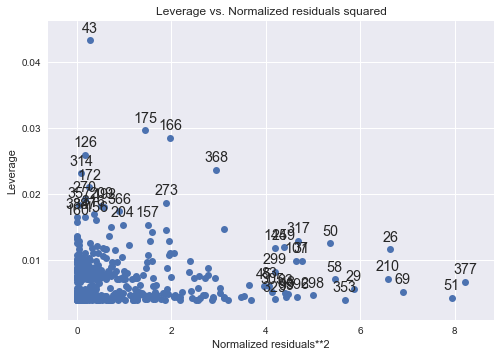

In [18]:
plot_leverage_resid2(lm6_fit);

# 11.a

In [19]:
np.random.seed(1)
x = np.random.normal(size=100)
y = 2 * x * np.random.normal(size=100)

In [20]:
lm7_fit = sm.OLS(endog=y, exog=x).fit()

lm7_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     4.022
Date:                Mon, 03 Jul 2017   Prob (F-statistic):             0.0477
Time:                        22:54:10   Log-Likelihood:                -192.27
No. Observations:                 100   AIC:                             386.5
Df Residuals:                      99   BIC:                             389.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3759      0.187      2.005      0.048       0.004       0.748
==============================================================================
Omnibus:                       51.191   Durbin-Watson:                   1.530
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              280.248
Skew:                           1.522   Prob(JB):                     1.40e-61
Kurtosis:                      10.615   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 11.b

In [21]:
lm8_fit = sm.OLS(endog=x, exog=y).fit()

lm8_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     4.022
Date:                Mon, 03 Jul 2017   Prob (F-statistic):             0.0477
Time:                        22:54:10   Log-Likelihood:                -127.94
No. Observations:                 100   AIC:                             257.9
Df Residuals:                      99   BIC:                             260.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1038      0.052      2.005      0.048       0.001       0.207
==============================================================================
Omnibus:                        0.684   Durbin-Watson:                   2.100
Prob(Omnibus):                  0.710   Jarque-Bera (JB):                0.542
Skew:                          -0.180   Prob(JB):                        0.763
Kurtosis:                       2.982   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 11.c
Stats look same, but coeff and SE differs

# 11.d

In [22]:
#TODO?

# 11.e
Surely, as the formula shows interchangeable `x` and `y`

# 11.f

In [23]:
lm9_1 = sm.OLS(endog=y, exog=sm.add_constant(x)).fit()
lm9_2 = sm.OLS(endog=x, exog=sm.add_constant(y)).fit()

lm9_1.tvalues[1], lm9_2.tvalues[1]

(1.9386104595445661, 1.9386104595445666)

# 12.a

When $Y^2$ is equal to $X^2$

# 12.b

In [24]:
np.random.seed(1)
x = np.random.normal(size=100)
y = np.random.normal(size=100)

In [25]:
lm10_1 = sm.OLS(endog=y, exog=sm.add_constant(x)).fit()
lm10_2 = sm.OLS(endog=x, exog=sm.add_constant(y)).fit()

lm10_1.params[1], lm10_2.params[1]

(0.095427133651171614, 0.08607652570024836)

# 12.c

In [26]:
np.random.seed(1)
x = np.random.normal(size=100)
y = x * -1

In [27]:
lm11_1 = sm.OLS(endog=y, exog=sm.add_constant(x)).fit()
lm11_2 = sm.OLS(endog=x, exog=sm.add_constant(y)).fit()

lm11_1.params[1], lm11_2.params[1]

(-1.0, -1.0)

# 13.a & 13.b & 13.c

In [28]:
np.random.seed(1)
x = np.random.normal(0, 1, 100)
eps = np.random.normal(0, np.sqrt(0.25), 100)
y = -1 + 0.5 * x + eps

- length of y: 100
- $\beta_0 = -1$
- $\beta_1 = 0.5$

# 13.d

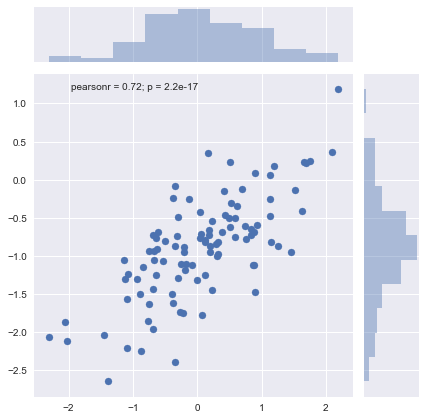

In [29]:
sns.jointplot(x, y);

highly linear relationship

# 13.e

In [30]:
lm12_fit = sm.OLS(y, sm.add_constant(x)).fit()
(lm12_fit.params[0], -1) , (lm12_fit.params[1], 0.5)

((-0.9264932351508991, -1), (0.54771356682558592, 0.5))

# 13.f

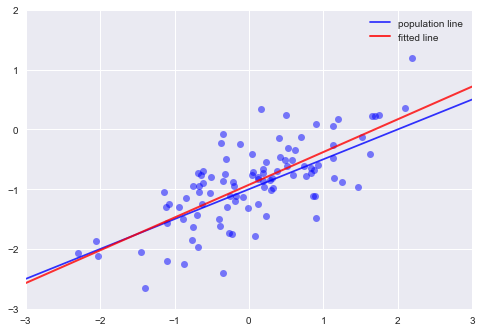

In [31]:
f = abline_plot(-1, 0.5, color='blue', alpha=0.8, label='population line')
ax = f.axes[0]
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 2)
sns.regplot(x, y, ax=ax, ci=False, 
            scatter_kws={'color': 'blue', 'alpha': 0.5}, 
            line_kws={'color': 'red', 'alpha': 0.8, 'label': 'fitted line', 'lw': 2})
ax.legend();

# 13.g

In [32]:
df = pd.DataFrame({'y': y, 'x': x})

lm13_fit = smf.ols(formula='y ~ x + np.power(x, 2)', data=df).fit()
lm13_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     52.96
Date:                Mon, 03 Jul 2017   Prob (F-statistic):           2.83e-16
Time:                        22:54:11   Log-Likelihood:                -65.107
No. Observations:                 100   AIC:                             136.2
Df Residuals:                      97   BIC:                             144.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.9325      0.058    -16.158      0.000      -1.047      -0.818
x                  0.5468      0.053     10.229      0.000       0.441       0.653
np.power(x, 2)     0.0077      0.043      0.181      0.856      -0.077       0.092
==============================================================================
Omnibus:                        0.893   Durbin-Watson:                   2.152
Prob(Omnibus):                  0.640   Jarque-Bera (JB):                0.552
Skew:                          -0.170   Prob(JB):                        0.759
Kurtosis:                       3.132   Cond. No.                         2.10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

no improvement, same $R^2$, even lower adjusted $R^2$

# 13.h

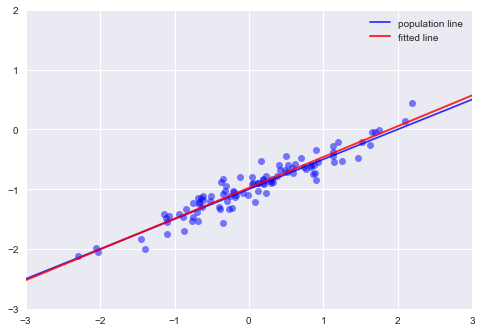

In [33]:
np.random.seed(1)
x = np.random.normal(0, 1, 100)
eps = np.random.normal(0, np.sqrt(0.025), 100)
y = -1 + 0.5 * x + eps

f = abline_plot(-1, 0.5, color='blue', alpha=0.8, label='population line')
ax = f.axes[0]
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 2)
sns.regplot(x, y, ax=ax, ci=False, 
            scatter_kws={'color': 'blue', 'alpha': 0.5}, 
            line_kws={'color': 'red', 'alpha': 0.8, 'label': 'fitted line', 'lw': 2})
ax.legend();

In [34]:
df = pd.DataFrame({'y': y, 'x': x})

lm13_fit = smf.ols(formula='y ~ x', data=df).fit()
lm13_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     945.9
Date:                Mon, 03 Jul 2017   Prob (F-statistic):           3.82e-52
Time:                        22:54:11   Log-Likelihood:                 50.005
No. Observations:                 100   AIC:                            -96.01
Df Residuals:                      98   BIC:                            -90.80
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9768      0.015    -65.734      0.000      -1.006      -0.947
x              0.5151      0.017     30.755      0.000       0.482       0.548
==============================================================================
Omnibus:                        0.898   Durbin-Watson:                   2.157
Prob(Omnibus):                  0.638   Jarque-Bera (JB):                0.561
Skew:                          -0.172   Prob(JB):                        0.755
Kurtosis:                       3.127   Cond. No.                         1.15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 13.i

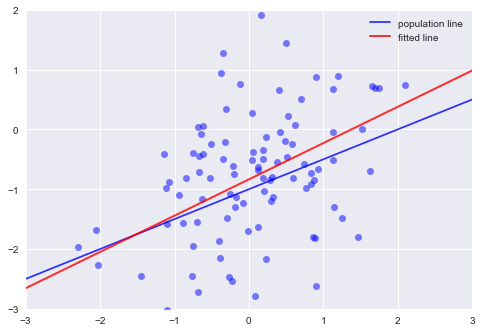

In [35]:
np.random.seed(1)
x = np.random.normal(0, 1, 100)
eps = np.random.normal(0, np.sqrt(1.25), 100)
y = -1 + 0.5 * x + eps

f = abline_plot(-1, 0.5, color='blue', alpha=0.8, label='population line')
ax = f.axes[0]
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 2)
sns.regplot(x, y, ax=ax, ci=False, 
            scatter_kws={'color': 'blue', 'alpha': 0.5}, 
            line_kws={'color': 'red', 'alpha': 0.8, 'label': 'fitted line', 'lw': 2})
ax.legend();

In [36]:
df = pd.DataFrame({'y': y, 'x': x})

lm13_fit = smf.ols(formula='y ~ x', data=df).fit()
lm13_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     26.24
Date:                Mon, 03 Jul 2017   Prob (F-statistic):           1.51e-06
Time:                        22:54:11   Log-Likelihood:                -145.60
No. Observations:                 100   AIC:                             295.2
Df Residuals:                      98   BIC:                             300.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.8356      0.105     -7.953      0.000      -1.044      -0.627
x              0.6067      0.118      5.123      0.000       0.372       0.842
==============================================================================
Omnibus:                        0.898   Durbin-Watson:                   2.157
Prob(Omnibus):                  0.638   Jarque-Bera (JB):                0.561
Skew:                          -0.172   Prob(JB):                        0.755
Kurtosis:                       3.127   Cond. No.                         1.15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 13.i

CIs can be seen in the summary tables

# 14.a

In [39]:
np.random.seed(1)
x1 = np.random.uniform(size=100)
x2 = 0.5 * x1 * np.random.normal(size=100) / 10
y = 2 + 2 * x1 + 0.3 * x2 + np.random.normal(size=100)

$$
\begin{aligned}
\hat{y}&=2+2{x_1}+0.3{x_2}+\epsilon$ \\
\beta_0&=2 \\
\beta_1&=2 \\
\beta_2&=0.3 \\
\end{aligned}
$$

# 14.b

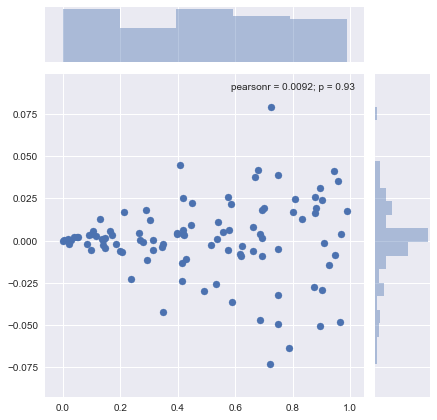

In [41]:
sns.jointplot(x1, x2);

# 14.c

In [42]:
df = pd.DataFrame({'y': y, 'x1': x1, 'x2': x2})

lm14_fit = smf.ols(formula='y ~ x1 + x2', data=df).fit()
lm14_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     13.76
Date:                Mon, 03 Jul 2017   Prob (F-statistic):           5.48e-06
Time:                        23:01:54   Log-Likelihood:                -142.96
No. Observations:                 100   AIC:                             291.9
Df Residuals:                      97   BIC:                             299.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2392      0.198     11.307      0.000       1.846       2.632
x1             1.7314      0.349      4.967      0.000       1.039       2.423
x2             7.3222      4.452      1.645      0.103      -1.515      16.159
==============================================================================
Omnibus:                        0.854   Durbin-Watson:                   2.075
Prob(Omnibus):                  0.653   Jarque-Bera (JB):                0.831
Skew:                          -0.214   Prob(JB):                        0.660
Kurtosis:                       2.875   Cond. No.                         48.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- can reject ${H}_0:\beta_1=0$
- can't reject ${H}_0:\beta_2=0$

# 14.d

In [43]:
lm15_fit = smf.ols(formula='y ~ x1', data=df).fit()
lm15_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     24.40
Date:                Mon, 03 Jul 2017   Prob (F-statistic):           3.23e-06
Time:                        23:04:47   Log-Likelihood:                -144.33
No. Observations:                 100   AIC:                             292.7
Df Residuals:                      98   BIC:                             297.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2416      0.200     11.222      0.000       1.845       2.638
x1             1.7367      0.352      4.939      0.000       1.039       2.434
==============================================================================
Omnibus:                        0.234   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.890   Jarque-Bera (JB):                0.416
Skew:                          -0.013   Prob(JB):                        0.812
Kurtosis:                       2.685   Cond. No.                         4.26
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- can reject ${H}_0:\beta_1=0$

# 14.e

In [45]:
lm16_fit = smf.ols(formula='y ~ x2', data=df).fit()
lm16_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     2.302
Date:                Mon, 03 Jul 2017   Prob (F-statistic):              0.132
Time:                        23:05:14   Log-Likelihood:                -154.29
No. Observations:                 100   AIC:                             312.6
Df Residuals:                      98   BIC:                             317.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.0803      0.114     26.927      0.000       2.853       3.307
x2             7.5267      4.961      1.517      0.132      -2.318      17.371
==============================================================================
Omnibus:                        0.058   Durbin-Watson:                   2.177
Prob(Omnibus):                  0.972   Jarque-Bera (JB):                0.118
Skew:                           0.055   Prob(JB):                        0.943
Kurtosis:                       2.873   Cond. No.                         43.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- can't reject ${H}_0:\beta_2=0$

# 14.f

No contradiction?

# 14.g

In [50]:
no = {'x1': 0.1, 'x2': 0.8, 'y': 6}
df2 = df.append(no, ignore_index=True)

In [51]:
lm17_fit = smf.ols(formula='y ~ x1 + x2', data=df2).fit()
lm17_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     17.68
Date:                Mon, 03 Jul 2017   Prob (F-statistic):           2.78e-07
Time:                        23:11:30   Log-Likelihood:                -144.08
No. Observations:                 101   AIC:                             294.2
Df Residuals:                      98   BIC:                             302.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2346      0.197     11.328      0.000       1.843       2.626
x1             1.7410      0.347      5.015      0.000       1.052       2.430
x2             4.7064      1.245      3.782      0.000       2.237       7.176
==============================================================================
Omnibus:                        0.386   Durbin-Watson:                   2.102
Prob(Omnibus):                  0.824   Jarque-Bera (JB):                0.467
Skew:                          -0.141   Prob(JB):                        0.792
Kurtosis:                       2.822   Cond. No.                         13.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
lm18_fit = smf.ols(formula='y ~ x1', data=df2).fit()
lm18_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     18.57
Date:                Mon, 03 Jul 2017   Prob (F-statistic):           3.87e-05
Time:                        23:11:37   Log-Likelihood:                -150.96
No. Observations:                 101   AIC:                             305.9
Df Residuals:                      99   BIC:                             311.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.3520      0.207     11.336      0.000       1.940       2.764
x1             1.5813      0.367      4.309      0.000       0.853       2.309
==============================================================================
Omnibus:                        2.039   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.361   Jarque-Bera (JB):                1.484
Skew:                           0.263   Prob(JB):                        0.476
Kurtosis:                       3.277   Cond. No.                         4.23
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
lm19_fit = smf.ols(formula='y ~ x1', data=df2).fit()
lm19_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     18.57
Date:                Mon, 03 Jul 2017   Prob (F-statistic):           3.87e-05
Time:                        23:11:39   Log-Likelihood:                -150.96
No. Observations:                 101   AIC:                             305.9
Df Residuals:                      99   BIC:                             311.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.3520      0.207     11.336      0.000       1.940       2.764
x1             1.5813      0.367      4.309      0.000       0.853       2.309
==============================================================================
Omnibus:                        2.039   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.361   Jarque-Bera (JB):                1.484
Skew:                           0.263   Prob(JB):                        0.476
Kurtosis:                       3.277   Cond. No.                         4.23
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

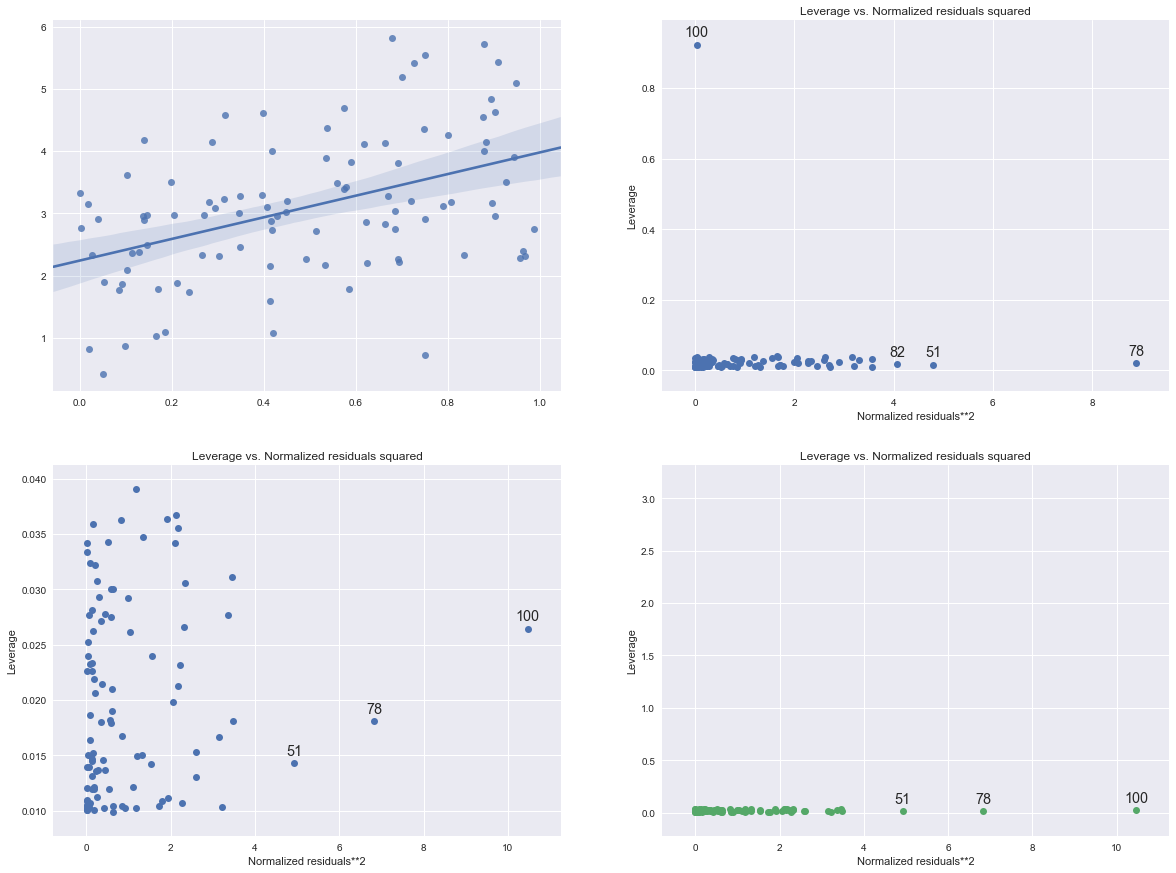

In [66]:
f, axes = plt.subplots(2, 2, sharex=False, sharey=False)
f.set_figwidth(20)
f.set_figheight(15)
sns.regplot(x1, y, ax=axes[0, 0])
plot_leverage_resid2(lm17_fit, ax=axes[0, 1])
plot_leverage_resid2(lm18_fit, ax=axes[1, 0])
plot_leverage_resid2(lm19_fit, ax=axes[1, 1]);

# 15.a

In [67]:
#TODO